In [48]:
import pandas as pd 
import numpy as np
from langdetect import detect
import seaborn as sns
import io 
import matplotlib.pyplot as plt
import boto3
from datetime import datetime as dt
from s3_credentials import *

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [15]:
cd '/Users/admin/Jedha/'

/Users/admin/Jedha


In [16]:
session = boto3.Session(aws_access_key_id= YOUR_ACCESS_KEY, 
                        aws_secret_access_key= YOUR_SECRET_KEY)

s3 = session.resource("s3")
client = session.client("s3")

In [17]:
# full_dataset_reworked
obj = s3.Object('jedha-fake-reviews-project', "datasets/full_dataset.csv")
dataset = pd.read_csv(io.BytesIO(obj.get()['Body'].read()), low_memory = False, index_col=0)

In [18]:
#_____________________________________________________________________
######### Cleaning the dataset and adding new columns #########
#_____________________________________________________________________

#we drop rows in which restaurant infos are not available (miss scraped)
dataset = dataset.dropna(subset = ['restaurant_average_rating', 'restaurant_reviews_count', 'restaurant_expensiveness', 'restaurant_name'])

#adding a column with the length of the text review
dataset['text_length'] = dataset['text_review'].apply(lambda x : len(x))

#_____________________________________________________________________
######### Fixing existing columns values and types #########
#_____________________________________________________________________

#for the user_total_image_posted column, if user_total_image_posted is NA it means there is there's no image
    # so we set the value to 0
dataset.loc[dataset['user_total_image_posted'].isna(), 'user_total_image_posted'] = 0

#for the date column,  there is some miss scraps that we want to fix
    # a correct data must have a length of 10 , if it is smaller than 10 it's becasue we scrapped the number of images of the user instead
    # we may have to scrap again those lines to fix it
    # we keep only the rows where the date is correct 
mask_not_date = dataset['date'].apply(lambda x: len(x)) < 10
dataset = dataset.loc[mask_not_date == False, :]
    # if te length is greater than 10 is it is beacause we scraped the date + somme additional words ('Avis mis à jour') so we will keep only the part with the date
mask_date_to_fix = dataset['date'].apply(lambda x: len(x)) > 10
dataset.loc[mask_date_to_fix, 'date' ] = dataset.loc[mask_date_to_fix, 'date' ].str.split('\n').str[0]
    #finally we can convert the date column to a datetime format
dataset['date'] = pd.to_datetime(dataset['date'])

#for the photos_for_review column, 
    # value -1 is in fact 0 (no photos found by the scraper)
dataset.loc[dataset['photos_for_review'] == '-1.0', 'photos_for_review' ] = '0'
    # value L is in fact 0 (no photos found by the scraper but scraped the first letter of "L'avis du jour" which happens when the reviews was updated by the user)
dataset.loc[dataset['photos_for_review'] == 'L', 'photos_for_review' ] = '0'
    # finally we can convert the photos_for_review column to an int format
dataset['photos_for_review'] = dataset['photos_for_review'].astype('int')

#for the photos_for_review column, 
    # when there's no info about the expensiveness we set it to -1
dataset.loc[dataset['restaurant_expensiveness'] == 'N/C', 'restaurant_expensiveness']  = -1
    # we can convert the restaurant_expensiveness column to an int format
dataset['restaurant_expensiveness'] = dataset['restaurant_expensiveness'].astype('int')

In [19]:
dataset['is_real_review'] = dataset['is_real_review'].apply(lambda x: 1 if x == 0 else 0)
dataset.rename(columns={'is_real_review': 'is_fake_review'}, inplace=True)

In [20]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 96731
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       90275 non-null  datetime64[ns]
 1   username                   90275 non-null  object        
 2   photos_for_review          90275 non-null  int64         
 3   rating                     90275 non-null  float64       
 4   text_review                90275 non-null  object        
 5   user_location              90271 non-null  object        
 6   user_friends_count         90275 non-null  int64         
 7   user_reviews_count         90275 non-null  int64         
 8   user_total_image_posted    90275 non-null  float64       
 9   restaurant_average_rating  90275 non-null  float64       
 10  restaurant_reviews_count   90275 non-null  float64       
 11  restaurant_expensiveness   90275 non-null  int64         
 12  rest

In [123]:
dataset.describe()

,photos_for_review,rating,user_friends_count,user_reviews_count,user_total_image_posted,restaurant_average_rating,restaurant_reviews_count,restaurant_expensiveness,is_fake_review,text_length
count,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000
mean,0.350496,3.715924,79.328297,80.270363,138.908158,3.820321,108.243035,2.117098,0.185611,498.003290
std,1.118769,1.192162,865.098163,158.443250,563.206491,0.520391,189.866010,0.964022,0.388794,444.105663
min,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,-1.000000,0.000000,1.000000
25%,0.000000,3.000000,0.000000,3.000000,0.000000,3.500000,21.000000,2.000000,0.000000,211.000000
50%,0.000000,4.000000,1.000000,12.000000,0.000000,4.000000,52.000000,2.000000,0.000000,368.000000
75%,0.000000,5.000000,14.000000,79.000000,24.000000,4.000000,120.000000,3.000000,0.000000,633.000000
max,9.000000,5.000000,22811.000000,1851.000000,10543.000000,5.000000,1810.000000,4.000000,1.000000,4998.000000


In [22]:
dataset.groupby('restaurant_expensiveness')['is_fake_review'].mean()

restaurant_expensiveness
-1    0.192571
 1    0.203824
 2    0.193776
 3    0.165671
 4    0.149825
Name: is_fake_review, dtype: float64

In [130]:
print('real_review | mean_user_review_count: ', dataset.loc[dataset['is_fake_review']==0, 'user_reviews_count'].mean())
print('fake_review | mean_user_review_count: ', dataset.loc[dataset['is_fake_review']==1, 'user_reviews_count'].mean())
print('-----------------------------------------------------------------------------------------')
print('real_review | mean_user_friend_count: ', dataset.loc[dataset['is_fake_review']==0, 'user_friends_count'].mean())
print('fake_review | mean_user_friend__count: ', dataset.loc[dataset['is_fake_review']==1, 'user_friends_count'].mean())
print( )
print('the high mean in user friend count for fake_review is high due to an extreme value for a specific user which brings a huge bias here ')
print('max value of friends count among the fake reviews : ', dataset.loc[dataset['is_fake_review']==1, 'user_friends_count'].max())
print( )
print('-----------------------------------------------------------------------------------------')
print('real_review | mean_user_image_posted_count: ', dataset.loc[dataset['is_fake_review']==0, 'user_total_image_posted'].mean())
print('fake_review | mean_user_image_posted_count: ', dataset.loc[dataset['is_fake_review']==1, 'user_total_image_posted'].mean())



real_review | mean_user_review_count:  94.08211482745956
fake_review | mean_user_review_count:  19.6696108856529
-----------------------------------------------------------------------------------------
real_review | mean_user_friend_count:  43.476652293964825
fake_review | mean_user_friend__count:  236.6317736930055

the high mean in user friend count for fake_review is high due to an extreme value for a specific user which brings a huge bias here 
max value of friends count among the fake reviews :  22811

-----------------------------------------------------------------------------------------
real_review | mean_user_image_posted_count:  167.98895523606143
fake_review | mean_user_image_posted_count:  11.312604440200525


In [29]:
subdata['year'] = subdata['date'].dt.year
subdata['month'] = subdata['date'].dt.month
subdata['day_name'] = subdata['date'].dt.day_name()
subdata['day'] = subdata['date'].dt.day

In [30]:
subdata.head()

,date,is_fake_review,year,month,day_name,day
0,2007-08-21,0,2007,8,Tuesday,21
2,2006-07-26,0,2006,7,Wednesday,26
3,2004-10-14,0,2004,10,Thursday,14
4,2007-11-02,0,2007,11,Friday,2
5,2012-04-25,0,2012,4,Wednesday,25


In [31]:
dataset['language'].value_counts()

fr           85687
en            4049
de              91
es              90
it              80
ca              51
pt              38
nl              34
zh-cn           31
da              17
ro              11
af              10
id              10
sv               8
not_found        8
no               7
tl               7
pl               6
so               5
ja               5
lt               4
cy               4
hr               3
tr               3
fi               3
lv               2
hu               2
sl               2
cs               2
sq               2
sw               1
ko               1
et               1
Name: language, dtype: int64

In [32]:
mask_is_not_fr_en = (dataset['language'] != 'fr') & (dataset['language'] != 'en')
dataset.loc[mask_is_not_fr_en ,'language'] = 'other'

In [33]:
dataset['language'].value_counts()

fr       85687
en        4049
other      539
Name: language, dtype: int64

In [98]:
restaurant_expensiveness

0         4
2        22
4        10
5         2
6         1
         ..
96727     2
96728     4
96729     1
96730     1
96731     1
Name: user_reviews_count, Length: 67318, dtype: int64

In [35]:
dataset.groupby('language')['is_fake_review'].mean()

language
en       0.949370
fr       0.145425
other    0.836735
Name: is_fake_review, dtype: float64

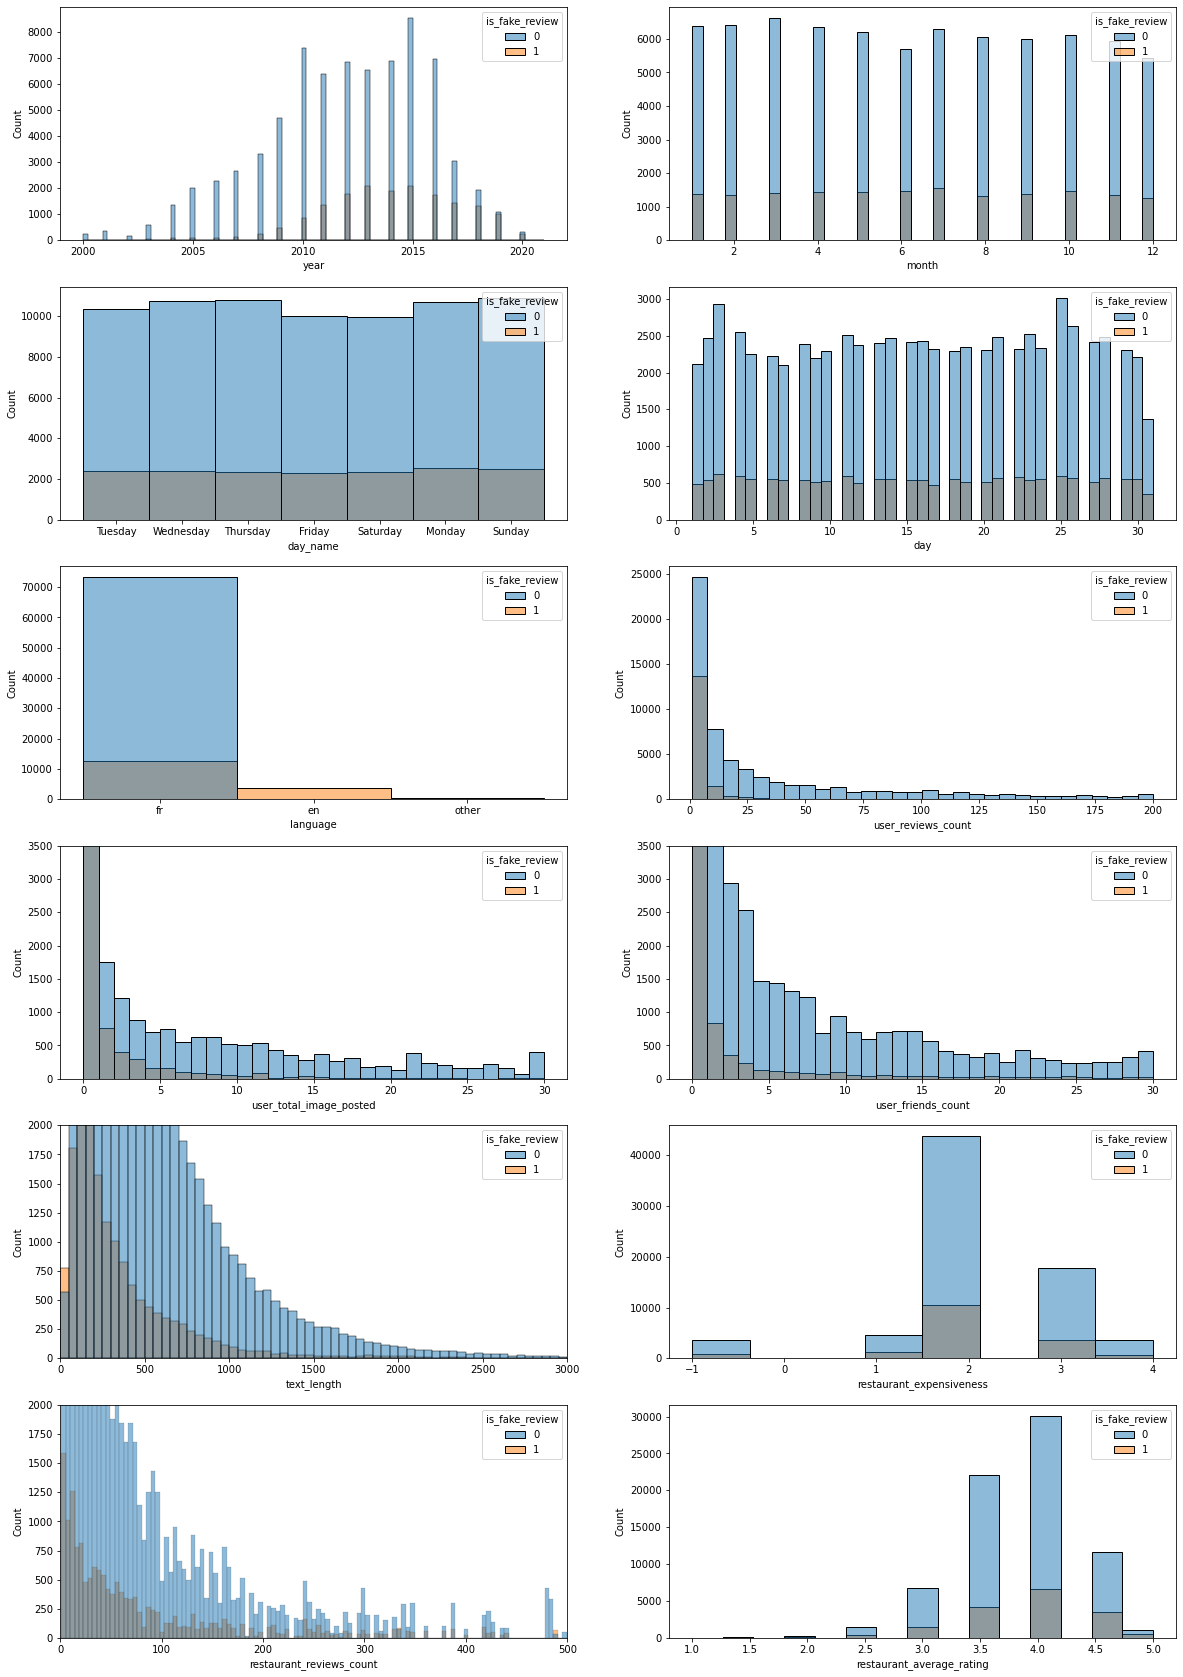

In [185]:
fig, ((ax1, ax2), (ax3, ax4) , (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12)) = plt.subplots(6,2, figsize=(20,30) )

ax1 = sns.histplot(data = subdata, x = 'year', hue = 'is_fake_review', ax = ax1)
ax2 = sns.histplot(data = subdata, x = 'month', hue = 'is_fake_review', ax = ax2)
ax3 = sns.histplot(data = subdata, x = 'day_name', hue = 'is_fake_review', ax = ax3)
ax4 = sns.histplot(data = subdata, x = 'day', hue = 'is_fake_review', ax = ax4)
ax5 = sns.histplot(data = dataset, x = 'language', hue = 'is_fake_review', ax = ax5)
ax6 = sns.histplot(x = dataset.loc[dataset['user_reviews_count'] <=200,  'user_reviews_count'], hue = dataset.loc[dataset['user_reviews_count'] <=200, 'is_fake_review'], bins =30, ax = ax6)
ax7 = sns.histplot(x = dataset.loc[dataset['user_total_image_posted'] <=30,  'user_total_image_posted'], hue = dataset.loc[dataset['user_total_image_posted'] <=30, 'is_fake_review'], bins =30, ax = ax7)
ax8 = sns.histplot(x = dataset.loc[dataset['user_friends_count'] <=30,  'user_friends_count'], hue = dataset.loc[dataset['user_friends_count'] <=30, 'is_fake_review'], bins =30, ax = ax8)
ax9 = sns.histplot(data = dataset, x = 'text_length', hue = 'is_fake_review', bins = 100, ax = ax9)
ax10 = sns.histplot(data = dataset, x = 'restaurant_expensiveness', hue = 'is_fake_review', bins = 8, ax = ax10)
ax11 = sns.histplot(data = dataset, x = 'restaurant_reviews_count', hue = 'is_fake_review', ax = ax11)
ax12 = sns.histplot(data = dataset, x = 'restaurant_average_rating', bins = 15, hue = 'is_fake_review', ax = ax12)





ax7.set_ylim(0,3500)
ax8.set_ylim(0,3500)
ax9.set_xlim(0,3000)
ax9.set_ylim(0,2000)
ax11.set_xlim(0,500)
ax11.set_ylim(0,2000)

plt.show()

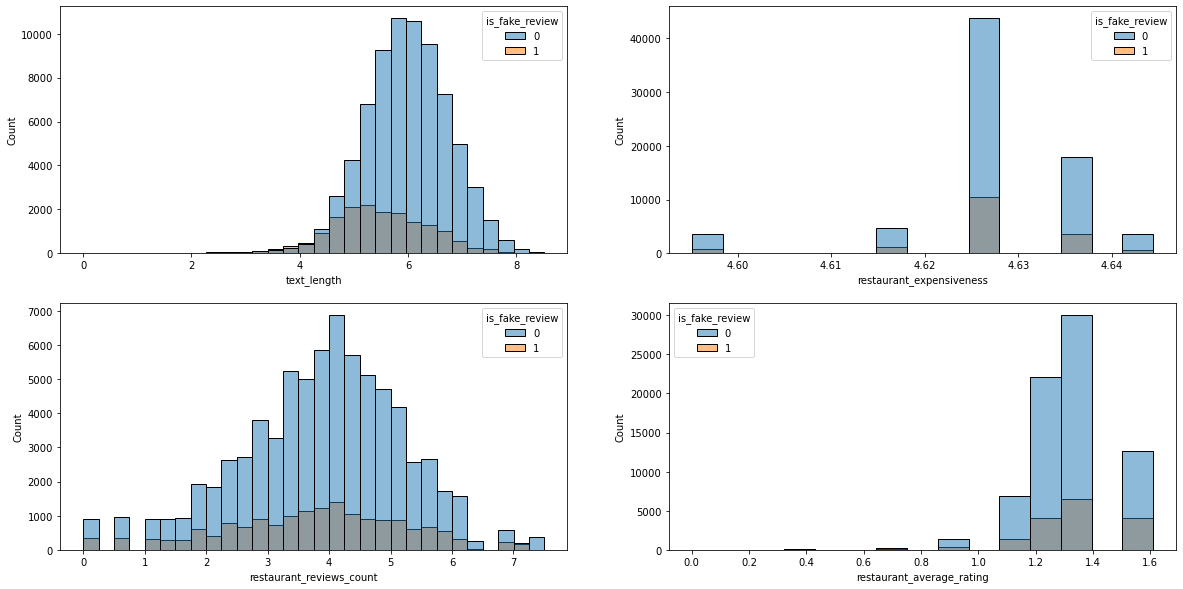

In [223]:
fig, ((ax1, ax2), (ax3, ax4) ) = plt.subplots(2,2, figsize=(20,10) )

#applying the log function makes the data seems like normal distributions
ax1 = sns.histplot(x = np.log(dataset['text_length']), hue = dataset['is_fake_review'], bins =30, ax = ax1)
ax2 = sns.histplot(x = np.log(dataset['restaurant_expensiveness']+100), hue = dataset['is_fake_review'], bins =15, ax = ax2)
ax3 = sns.histplot(x = np.log(dataset['restaurant_reviews_count']), hue = dataset['is_fake_review'], bins =30, ax = ax3)
ax4 = sns.histplot(x = np.log(dataset['restaurant_average_rating']), hue = dataset['is_fake_review'], bins =15, ax = ax4)


plt.show()

In [37]:
X = dataset[[c for c in dataset.columns if c not in ['date', 'username', 'text_review', 'user_location', 'restaurant_name', 'url', 'is_fake_review', 'url_not_recommended']]]
y = dataset['is_fake_review']

numeric_features = [index for index, c in enumerate(X.columns) if X[c].dtype != 'object']
categorical_features = [index for index, c in enumerate(X.columns) if X[c].dtype == 'object']

X = X.values
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=19, stratify = y)



In [38]:

# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])


# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
X_train = preprocessor.fit_transform(X_train)

# Preprocessings on test set
X_test = preprocessor.transform(X_test) 

In [66]:
# Train model
model = LogisticRegression(C=0.95, class_weight={0:1, 1:3.3}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


model.fit(X_train, y_train)


LogisticRegression(C=0.95, class_weight={0: 1, 1: 3.3})

In [ ]:
# grid search class weights with logistic regression for imbalance classification

# define grid
#cw_params = [{0:1, 1:3.3}]
cw_params = [{0:1, 1:i} for i in np.arange(0.97, 1.1, 0.01)]
#C_params = np.arange(0.1, 1.1, 0.1)
C_params = [0.95]
param_grid = dict(class_weight = cw_params, C = C_params)
#param_grid = dict(class_weight = cw_params)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=69)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
# execute the grid search
grid_result = grid.fit(X_test, y_test)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [67]:
print('f1 test :',f1_score(y_test, model.predict(X_test)))
print('f1 train :',f1_score(y_train, model.predict(X_train)))



f1 test : 0.556390977443609
f1 train : 0.5546986390149061


In [68]:

print(classification_report(y_true=y_test, y_pred=model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88     14704
           1       0.49      0.64      0.56      3351

    accuracy                           0.81     18055
   macro avg       0.70      0.74      0.72     18055
weighted avg       0.83      0.81      0.82     18055



In [50]:
scores_train = cross_val_score(model, X_train, y_train, cv=10, scoring='f1')
#predictions = cross_val_predict(model, X_train, Y_train, cv = 10)

print(scores_train)
print('score min :',scores_train.min())
print('score max :',scores_train.max())

[0.44381385 0.43966006 0.42305476 0.43030654 0.43348624 0.42816256
 0.41371296 0.41978148 0.43110349 0.42757822]
score min : 0.41371295758280074
score max : 0.4438138479001135


In [69]:
dataset.head()

,date,username,photos_for_review,rating,text_review,user_location,user_friends_count,user_reviews_count,user_total_image_posted,restaurant_average_rating,restaurant_reviews_count,restaurant_expensiveness,restaurant_name,url,is_fake_review,url_not_recommended,language,text_length
0,2007-08-21,Not_Yelp_User,0,5.0,Bon retour !\nJe suis revenue dans ce resto ap...,"Levallois-Perret, Hauts-de-Seine",0,4,0.0,3.0,19.0,-1,restaurant anatole,https://www.yelp.fr/biz/restaurant-anatole-lev...,0,https://www.yelp.fr/not_recommended_reviews/re...,fr,359
2,2006-07-26,Benjamin D.,0,3.0,A optimiser...\nCuisine très traditionnelle da...,"Bron, Rhône",0,22,0.0,3.0,19.0,-1,restaurant anatole,https://www.yelp.fr/biz/restaurant-anatole-lev...,0,https://www.yelp.fr/not_recommended_reviews/re...,fr,256
3,2004-10-14,Not_Yelp_User,0,3.0,Brasserie chic\nUne brasserie authentiquement ...,Marseille,11,155,0.0,3.0,19.0,-1,restaurant anatole,https://www.yelp.fr/biz/restaurant-anatole-lev...,0,https://www.yelp.fr/not_recommended_reviews/re...,fr,323
4,2007-11-02,Not_Yelp_User,0,4.0,Tres bien\nPetit diner entre amis. Les plats e...,"Boulogne-Billancourt, Hauts-de-Seine",0,10,0.0,3.0,19.0,-1,restaurant anatole,https://www.yelp.fr/biz/restaurant-anatole-lev...,0,https://www.yelp.fr/not_recommended_reviews/re...,fr,247
5,2012-04-25,Not_Yelp_User,0,4.0,Un bistrot bien sympathique\nNous avons mangé ...,Montpellier,0,2,0.0,3.0,19.0,-1,restaurant anatole,https://www.yelp.fr/biz/restaurant-anatole-lev...,0,https://www.yelp.fr/not_recommended_reviews/re...,fr,280


In [225]:
X  = pd.DataFrame(dict(
text_length = np.log(dataset['text_length']),
restaurant_expensiveness = np.log(dataset['restaurant_expensiveness']+100),
restaurant_reviews_count = np.log(dataset['restaurant_reviews_count']),
restaurant_average_rating = np.log(dataset['restaurant_average_rating'])
                        )
                    )
y = dataset['is_fake_review']


In [226]:
scaler = StandardScaler()

In [233]:
X = scaler.fit_transform(X)

,text_length,restaurant_expensiveness,restaurant_reviews_count,restaurant_average_rating
0,5.883322,4.595120,2.944439,1.098612
2,5.545177,4.595120,2.944439,1.098612
3,5.777652,4.595120,2.944439,1.098612
4,5.509388,4.595120,2.944439,1.098612
5,5.634790,4.595120,2.944439,1.098612
...,...,...,...,...
96727,5.273000,4.615121,1.791759,1.609438
96728,4.418841,4.615121,1.791759,1.609438
96729,5.968708,4.595120,0.000000,1.098612
96730,5.752573,4.595120,0.000000,1.098612
